In [2]:
import numpy as np
from matplotlib import pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import utils
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd


# Load ground truth data
cocoGt=COCO("cocoGt.json")

# Load prediction data
cocoDt=cocoGt.loadRes("cocoDt.json")

# Initialize COCOeval object
cocoEval = COCOeval(cocoGt, cocoDt, 'bbox')
cocoEval.params.useCats = 1

# Evaluate on a subset of images (optional)
# cocoEval.params.imgIds = [5]  # Remove this line to evaluate on all images

# Run evaluation
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.18s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=6.66s).
Accumulating evaluation results...
DONE (t=1.40s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.461
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.503
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.517
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.659
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.354
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.518
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

In [3]:
len(cocoEval.params.catIds)

80

In [ ]:
# increases score:
# prediction with high confidence but incorrect (FP)
# TP with low confidence, low IoU
# edge cases: small objects, big objects, low IoU, low confidence
# many predictions in one image
# many FP predictions in one image
# many FN in one image
# miss-classified objects with high/low confidence
# miss-classified prediciotn, and it is the most often miss-classified class

# finding insightful FN:
# many FN in one image
# FN with small area
# FN on the edge
# FN with tall/len object

# finding insightful TP:
# TP with low confidence
# TP with low IoU
# TP with small area

In [ ]:
# per-image stats:
# prediction count (TP+FP)
# FP count
# FN count
# TP + low conf + low IoU (avg on image)
# FP + high conf (avg on image)
# many rare classes (avg)

# per-prediction stats:
# TP + low conf
# TP + low IoU
# FP + high conf
# rare class
# TP, but incorrect class + high conf
# FN + small area (?)

# image_id / ann_id

In [77]:
from collections import defaultdict

aRng = cocoEval.params.areaRng[0]
# eval_imgs = [ev for ev in cocoEval.evalImgs if ev is not None and ev['aRng'] == aRng]

eval_img_dict = defaultdict(list) # img_id : dt/gt

for i, eval_img in enumerate(cocoEval.evalImgs):
    if eval_img is None or eval_img['aRng'] != aRng:
        continue
    img_id = eval_img['image_id']
    cat_id = eval_img['category_id']
    ious = cocoEval.ious[(img_id, cat_id)]
    # ! inplace operation
    eval_img['ious'] = ious
    eval_img_dict[img_id].append(eval_img)

eval_img_dict = dict(eval_img_dict)

In [78]:
iou_t = 0
matches = []
for img_id, eval_imgs in eval_img_dict.items():
    for eval_img in eval_imgs:

        dtIds = np.array(eval_img['dtIds'])
        gtIds = np.array(eval_img['gtIds'])
        dtm = eval_img['dtMatches'][iou_t]
        gtm = eval_img['gtMatches'][iou_t]
        dtIgnore = eval_img['dtIgnore'][iou_t]
        gtIgnore = eval_img['gtIgnore']

        # True Positives
        tp_idxs = np.nonzero(dtm)[0]
        for i in tp_idxs:
            if dtIgnore[i]:
                continue
            dt_id = dtIds[i]
            gt_id = int(dtm[i])
            gt_idx = np.where(gtIds == gt_id)[0]
            iou = eval_img['ious'][i, gt_idx]
            score = eval_img['dtScores'][i]
            match = {
                "image_id": eval_img['image_id'],
                "category_id": eval_img['category_id'],
                "dt_id": dt_id,
                "gt_id": gt_id,
                "type": "TP",
                "score": score,
                "iou": iou,
            }
            assert iou >= 0.5
            matches.append(match)

        # False Positives
        fp_idxs = np.nonzero(dtm == 0)[0]
        for i in fp_idxs:
            dt_id = dtIds[i]
            score = eval_img['dtScores'][i]
            match = {
                "image_id": eval_img['image_id'],
                "category_id": eval_img['category_id'],
                "dt_id": dt_id,
                "gt_id": None,
                "type": "FP",
                "score": score,
                "iou": None,
            }
            matches.append(match)

        # False Negatives
        fn_idxs = np.nonzero(gtm == 0)[0]
        for i in fn_idxs:
            if gtIgnore[i]:
                continue
            gt_id = gtIds[i]
            match = {
                "image_id": eval_img['image_id'],
                "category_id": eval_img['category_id'],
                "dt_id": None,
                "gt_id": gt_id,
                "type": "FN",
                "score": None,
                "iou": None,
            }
            matches.append(match)

In [79]:
len(matches), len(cocoDt.anns), len(cocoGt.anns)

(44425, 33765, 36781)

In [ ]:
# (N_imgs, 5), 5 = TP, FP, FN, score, iou

In [85]:
# Per-image stats
img_ids = cocoEval.params.imgIds

per_image = np.zeros((len(img_ids), 5))

imgId2idx = {img_id: idx for idx, img_id in enumerate(img_ids)}
idx2imgId = {idx: img_id for img_id, idx in imgId2idx.items()}

for match in matches:
    idx = imgId2idx[match['image_id']]
    if match["type"] == "TP":
        per_image[idx, 0] += 1
        per_image[idx, 3] += match["score"]
        per_image[idx, 4] += match["iou"]
    elif match["type"] == "FP":
        per_image[idx, 1] += 1
        per_image[idx, 3] += match["score"]
    elif match["type"] == "FN":
        per_image[idx, 2] += 1


per_image[:, 3] /= (per_image[:, 0] + per_image[:, 1])
per_image[:, 4] /= per_image[:, 0]

/tmp/ipykernel_176538/1506004393.py:22: RuntimeWarning: invalid value encountered in divide
  per_image[:, 3] /= (per_image[:, 0] + per_image[:, 1])
/tmp/ipykernel_176538/1506004393.py:23: RuntimeWarning: invalid value encountered in divide
  per_image[:, 4] /= per_image[:, 0]


In [86]:
per_image

array([[14.        ,  5.        ,  6.        ,  0.62044165,  0.83257877],
       [ 1.        ,  0.        ,  0.        ,  0.97595006,  0.98117544],
       [ 4.        ,  1.        , 13.        ,  0.80398173,  0.91882585],
       ...,
       [ 2.        ,  0.        ,  0.        ,  0.74393168,  0.82521037],
       [ 1.        ,  0.        ,  0.        ,  0.90351409,  0.93050117],
       [ 9.        ,  0.        ,  4.        ,  0.67919539,  0.78294441]])

In [ ]:
# per-image stats:
# many prediction count (TP+FP)
# many FP count
# many FN count
# TP + low conf + low IoU (avg on image)
# FP + high conf (avg on image)
# many rare classes (avg)

In [87]:
pred_count = per_image[:, 0] + per_image[:, 1]

inds_sorted = np.argsort(pred_count)[::-1]
pred_count[inds_sorted]

array([56., 54., 47., ...,  0.,  0.,  0.])

In [88]:
inds_sorted[0]

3748

In [90]:
img_id = idx2imgId[inds_sorted[0]]

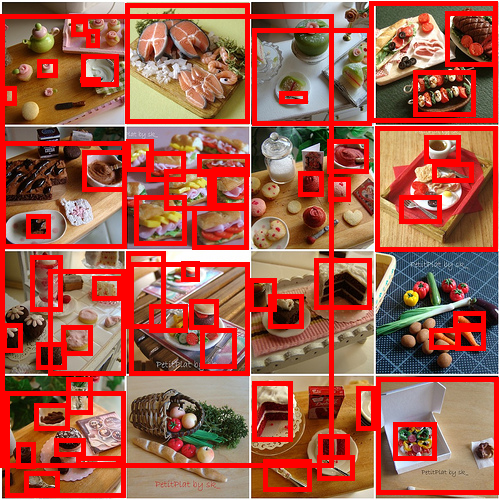

In [92]:
utils.show_gt_image(img_id, cocoGt, draw_label=False)

In [3]:
true_positives, false_positives, false_negatives, scores = utils.get_counts(cocoEval)

IndexError: index 80 is out of bounds for axis 0 with size 80